Vicenzino Matteo

#  Stabilità asintotica del modello Lokta-Volterra con una piccola immigrazione

Si vuole riprodurre i risultati ottenuti nel paper "**Asymptotic stability of a modified Lotka-Volterra model with small immigrations**" di Takeru Tahara, Maica Krizna Areja Gavina, Takenori Kawano, Jerrold M. Tubay, Jomar F. Rabajante, Hiromu Ito, Satoru Morita, Genki Ichinose, Takuya Okabe, Tatsuya Togashi, Kei-ichi Tainaka, Akira Shimizu, Takashi Nagatani & Jin Yoshimura

In particolare si vuole:
- Studiare la stabilità del sistema introducendo una piccola immigrazione (Type I)
- Studiare alcune varianti non lineari di LV ed effetto di una piccola immigrazione (Type II e III)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve
from scipy.linalg import eigvals

## Definizione del modello LV con immigrazione

Il modello descritto nella classe ```LV_immigration``` è il modello di Lotka-Volterra classico, a cui sono stati aggiunti dei fattori di immigrazione C e D che rappresentano l’immigrazione rispettivamente delle prede e dei predatori:

\begin{cases}
\frac{dx}{dt} = rx - axy + C(x) \\
\frac{dy}{dt} = bxy - my + D(y)
\end{cases}


L'immigrazione delle prede ```C(x)``` e dei predatori ```D(y)``` è modellizzata in due diversi casistiche:
1. introduzione nella popolazione di un numero costante di individui ad ogni unità di tempo
2. introduzione di un numero di individui inversamente proporzionale alla size della popolazione

$$C(x) = \begin{cases}
c, & c \geq 0 \text{  , caso costante}\\
\frac{c}{x}, & c > 0 \text{ , caso proporzionale}
\end{cases}$$

$$D(y) = \begin{cases}
d, & d \geq 0 \text{  , caso costante}\\
\frac{d}{y}, & d > 0 \text{ , caso proporzionale}
\end{cases}$$

In [ ]:
class LV_immigration():
    
    def __init__(self, r,a,b,m, x_0, Tmax):
        self.r = r # nascita delle prede
        self.a = a # caccia delle prede
        self.b = b # tasso di conversione prede in predatori
        self.m = m # morte naturale dei predatori
        
        self.x_0 = x_0
        self.t_span = (0, Tmax)
        self.t_eval = np.linspace(self.t_span[0], self.t_span[1], 10000)
        
    def C(self, x, case, c):
        if case == 'constant':
            return c
        elif case == 'proportional':
            return c/x if x > 0 else 0
        
    def D(self, y, case, d):
        if case == 'constant':
            return d
        elif case == 'proportional':
            return d/y if y > 0 else 0
        
        
    def lotka_volterra(self, t, x, case, c=0, d=0):
        U, V = x
        C_x = self.C(U, case, c)
        D_y = self.D(V, case, d)
        
        dU_dt = self.r*U - self.a*U*V + C_x
        dV_dt = self.b*U*V - self.m*V + D_y
        return [dU_dt, dV_dt]
    
    
    def find_equilibrium(self, case='constant', c=0, d=0, initial_guess=[1, 1]):
        """
        risolve il sisema di equazioni [dU_dt, dV_dt] = 0
        """
        return fsolve(lambda x: self.lotka_volterra(0, x, case, c, d), initial_guess)
    

    def compute_J(self, x_eq, case, c, d):
        """
        calcola analiticamente la Jacobiana per il modello Type I
        """
        U_eq, V_eq = x_eq
        
        # Derivate parziali
        dU_dx = self.r - self.a * V_eq
        dU_dy = -self.a * U_eq
        dV_dx = self.b * V_eq
        dV_dy = self.b * U_eq - self.m
        
        if case == 'proportional':
            dU_dx = dU_dx - c/(U_eq**2) if U_eq > 0 else dU_dx
            dV_dy = dV_dy - d/(V_eq**2) if V_eq > 0 else dV_dy
        
        J = np.array([[dU_dx, dU_dy],
                      [dV_dx, dV_dy]])
        
        return J
    
    def compute_stability(self, x_eq, case, c, d):
        
        J = self.compute_J(x_eq, case, c, d)
        
        # calcola traccia, determinante, autovalori
        trace = np.trace(J)
        det = np.linalg.det(J)
        eigenvalues = eigvals(J)
        
        if det > 0 and trace < 0:
            stability = "Locally asymptotically stable"
        elif det > 0 and abs(trace) < 1e-10:
            stability = "Unstable, limit cycle exists"
        else:
            stability = "Unstable" 
        
        return {
            'jacobian': J,
            'trace': trace,
            'determinant': det,
            'eigenvalues': eigenvalues,
            'stability': stability,
            'real_parts': [np.real(lam) for lam in eigenvalues],
            'imaginary_parts': [np.imag(lam) for lam in eigenvalues]
        }

        
    def solve(self, case, c=0, d=0):
        solution = solve_ivp(lambda t, x: self.lotka_volterra(t, x, case, c, d),
                             self.t_span, 
                             self.x_0, 
                             t_eval=self.t_eval, 
                             method='RK45', 
                             rtol=1e-6, 
                             atol=1e-9)
        return solution.y[0], solution.y[1], solution.t
    
    def plot(self, X,Y,t):
        
        # plot dei risultati
        plt.figure(figsize=(14, 6))

        # popolazione in funzione del tempo
        plt.subplot(1, 2, 1)
        plt.plot(t, X, label='Prey Population', color='blue')
        plt.plot(t, Y, label='Predator Population', color='red')
        plt.xlabel('Time')
        plt.ylabel('Population')
        plt.title('Population Dynamics Over Time')
        plt.legend()
        plt.grid(True)

        # piano delle fasi
        plt.subplot(1, 2, 2)
        plt.plot(X, Y, color='green')
        plt.xlabel('Prey Population')
        plt.ylabel('Predator Population')
        plt.title('Phase Plane Trajectory')
        plt.grid(True)

        plt.tight_layout()
        plt.show()

Per ogni modello viene analizzato il caso senza immigrazione e 4 diversi scenari di immigrazione, denominati come segue:

|   | immigrazione prede | immigrazione predatori  |
|----------|-------|--------|
| senza immigrazione | 0 | 0 |
| A1 | c | 0 |
| B1 | 0 | d |
| C1 | c/x | 0 |
| D1 | 0 | d/y |


## Risultati Type I - Modello Lineare

In [ ]:
# Parametri del modello
r = 0.1    # tasso di crescita prede
a = 0.1    # tasso di predazione
b = 0.3    # efficienza conversione
m = 0.2    # mortalità predatori
x_0 = [5, 5]  # condizioni iniziali [prede, predatori]
Tmax = 1500

**Caso senza immigrazione** <br>
Il risultato ottenuto dal modello LV classico è un equilibrio instabile, con la presenza di un ciclolimite

Equilibrio calcolato analiticamente:
 [0.66666667 1.        ]

 Unstable, limit cycle exists


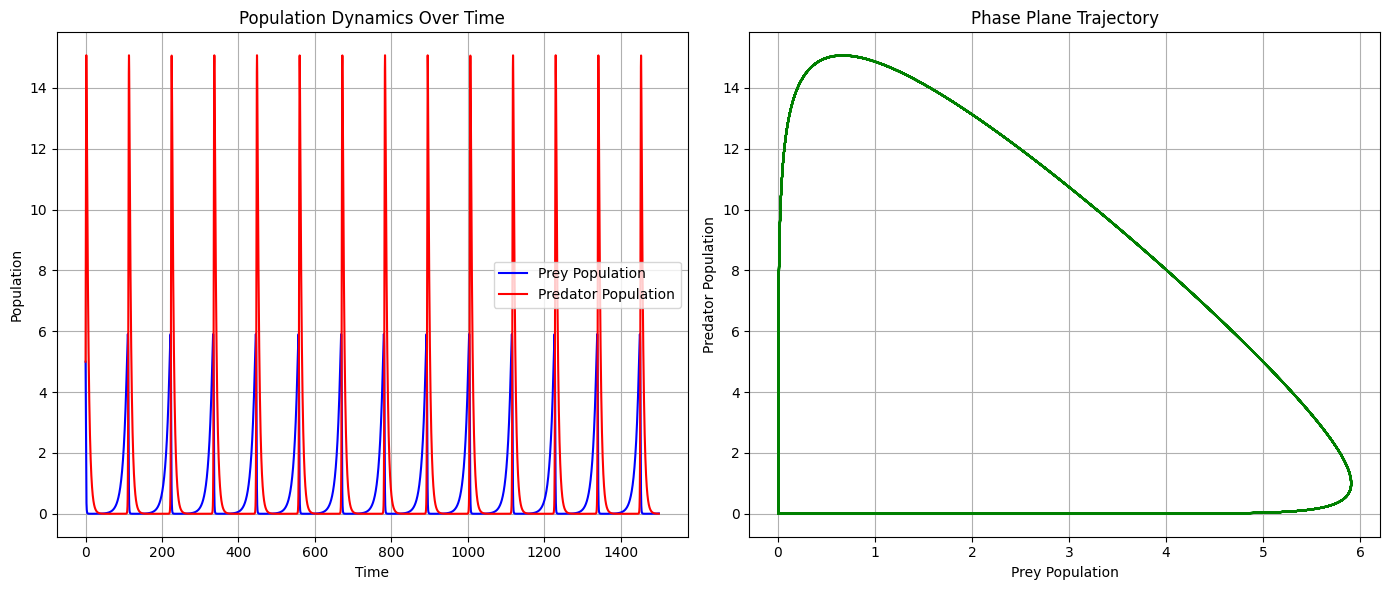

In [4]:
case = 'constant'
c = 0
d = 0

model = LV_immigration(r, a, b, m, x_0, Tmax)

# EQUILIBRIO
equilibrio = model.find_equilibrium(case, c, d)
print("Equilibrio calcolato analiticamente:\n", equilibrio)

# STABILITA
info_n1 = model.compute_stability(equilibrio, case, c, d)
print("\n", info_n1["stability"])

X, Y, t = model.solve(case, c, d)
model.plot(X, Y, t)

**Caso A1** <br>
Equilibrio $(x^*, y^*) = \left(\frac{m}{b}, \frac{mr + bc}{am}\right)$  <br>
è stabile se $\frac{bc}{2m} > 0$

Equilibrio calcolato analiticamente:
 [0.66666667 1.15      ]
Equilibrio calcolato con la formula formita dal paper:
 [0.6666666666666667, 1.15]

 Locally asymptotically stable


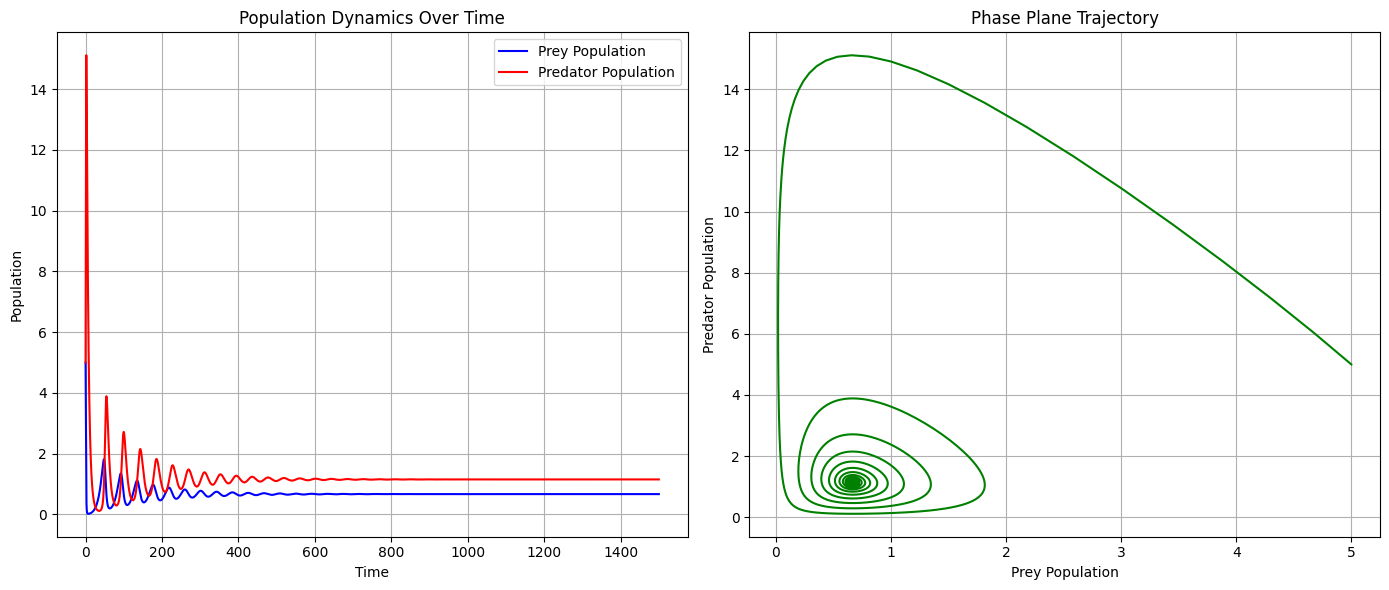

In [5]:
case_c = 'constant'
c = 0.01
d = 0

model = LV_immigration(r, a, b, m, x_0, Tmax)

# EQUILIBRIO
equilibrio = model.find_equilibrium(case, c, d)
print("Equilibrio calcolato analiticamente:\n", equilibrio)
# confronto con equilibrio del paper
eq = [m/b, (m*r+b*c)/(a*m)]
print("Equilibrio calcolato con la formula formita dal paper:\n", eq)

# STABILITA
info_cx1 = model.compute_stability(equilibrio, case, c, d)
print("\n", info_cx1["stability"])

X, Y, t = model.solve(case, c, d)
model.plot(X, Y, t)

**Caso B1** <br>
Equilibrio $(x^*, y^*) = \left(\frac{mr - ad}{br}, \frac{r}{a}\right)$ dove $mr > ad$  <br>
è stabile se $\frac{ad}{2r} > 0$

Equilibrio calcolato analiticamente:
 [0.63333333 1.        ]
Equilibrio calcolato con la formula formita dal paper:
 [0.6333333333333334, 1.0]

 Locally asymptotically stable


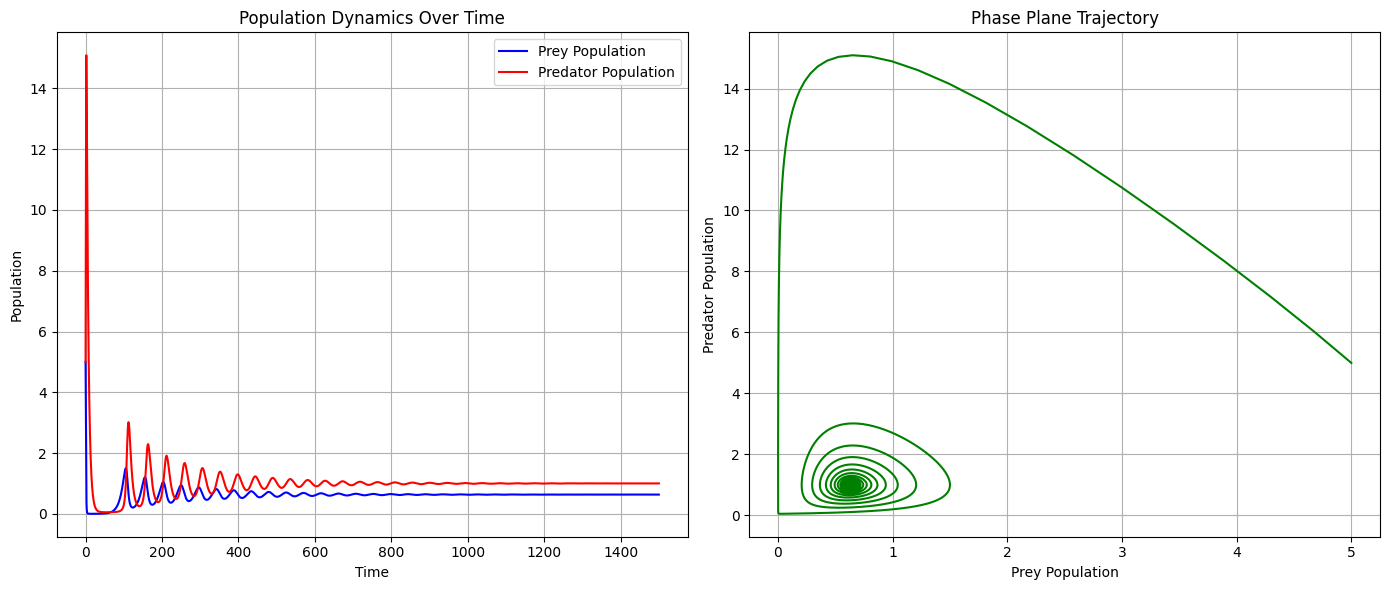

In [6]:
case_c = 'constant'
c = 0
d = 0.01

model = LV_immigration(r, a, b, m, x_0, Tmax)

# EQUILIBRIO
equilibrio = model.find_equilibrium(case, c, d)
print("Equilibrio calcolato analiticamente:\n", equilibrio)
# confronto con equilibrio del paper
eq = [(m*r-a*d)/(b*r), r/a]
print("Equilibrio calcolato con la formula formita dal paper:\n", eq)

# STABILITA
info_cy1 = model.compute_stability(equilibrio, case, c, d)
print("\n", info_cy1["stability"])

X, Y, t = model.solve(case, c, d)
model.plot(X, Y, t)

**Caso C1** <br>
Equilibrio $(x^*, y^*) = \left(\frac{m}{b}, \frac{m^2r + b^2c}{am^2}\right)$  <br>
è stabile se $\frac{b^2c}{m^2} > 0$

Equilibrio calcolato analiticamente:
 [0.66666667 1.15      ]
Equilibrio calcolato con la formula formita dal paper:
 [0.6666666666666667, 1.2249999999999999]

 Locally asymptotically stable


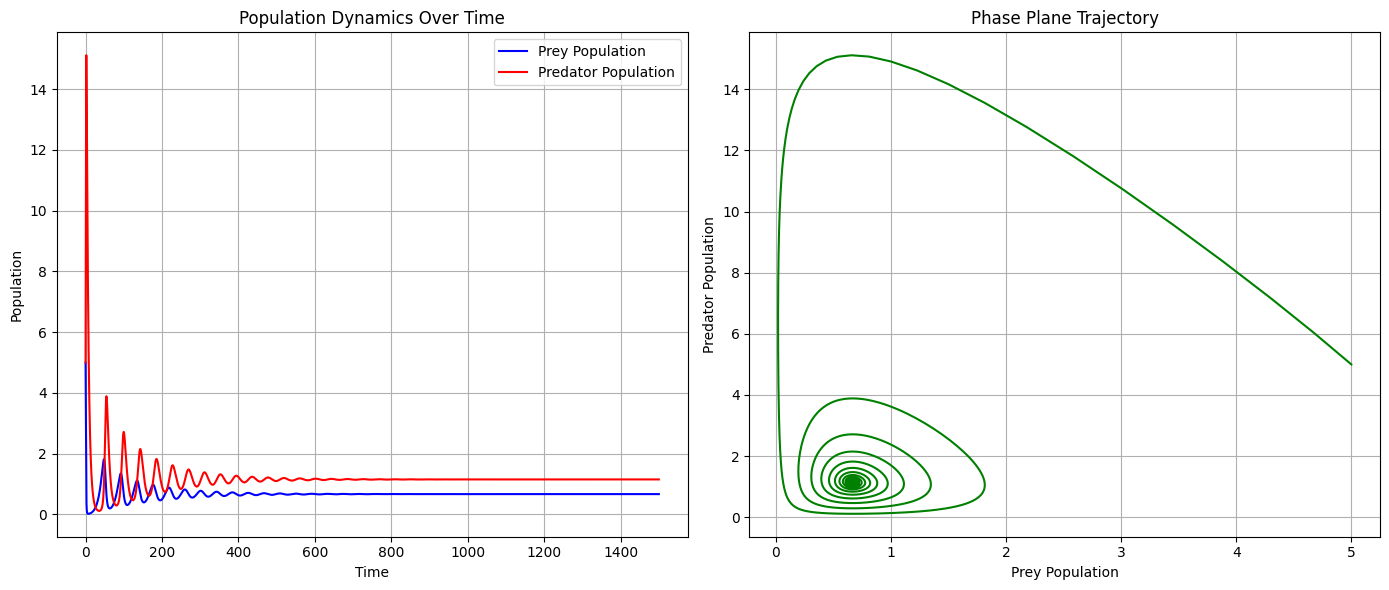

In [7]:
case_c = 'proportional'
c = 0.01
d = 0

model = LV_immigration(r, a, b, m, x_0, Tmax)

# EQUILIBRIO
equilibrio = model.find_equilibrium(case, c, d)
print("Equilibrio calcolato analiticamente:\n", equilibrio)
# confronto con equilibrio del paper
eq = [m/b, ((m**2)*r+(b**2)*c)/(a*(m**2))]
print("Equilibrio calcolato con la formula formita dal paper:\n", eq)

# STABILITA
info_px1 = model.compute_stability(equilibrio, case, c, d)
print("\n", info_px1["stability"])

X, Y, t = model.solve(case, c, d)
model.plot(X, Y, t)

**Caso D1** <br>
Equilibrio $(x^*, y^*) = \left(\frac{mr^2 - a^2d}{br^2}, \frac{r}{a}\right)$ dove $mr^2 > a^2d$  <br>
è stabile se $\frac{a^2d}{r^2} > 0$

Equilibrio calcolato analiticamente:
 [0.63333333 1.        ]
Equilibrio calcolato con la formula formita dal paper:
 [0.6333333333333334, 1.0]

 Locally asymptotically stable


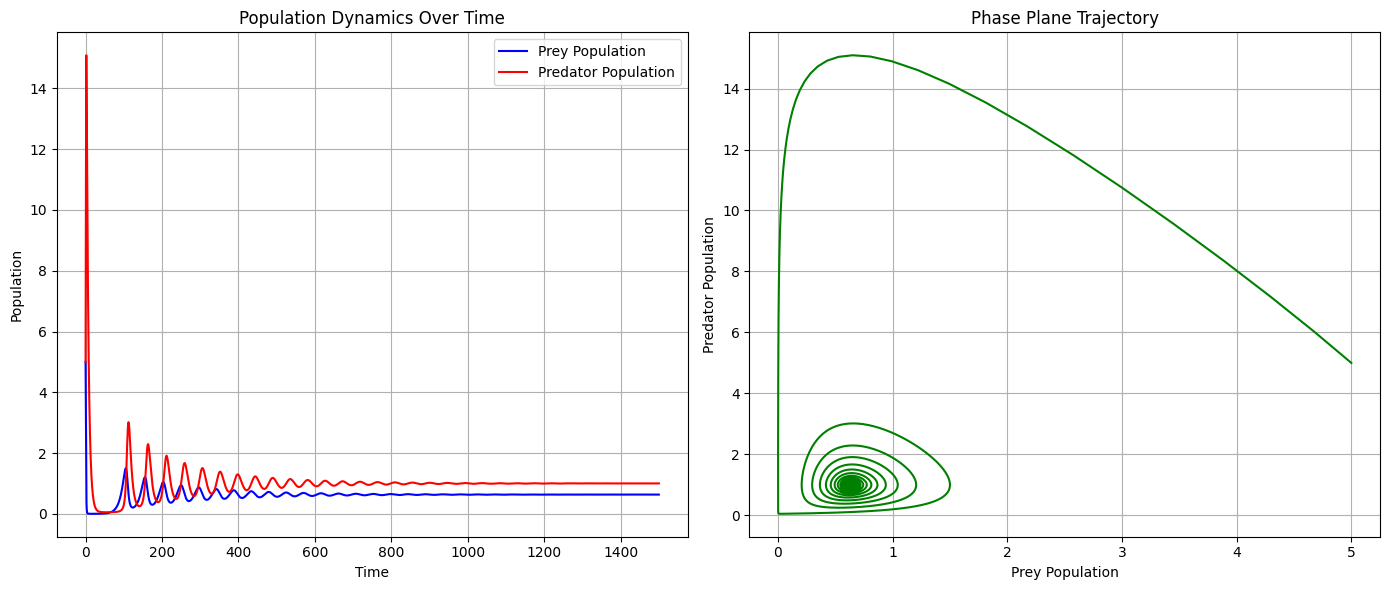

In [8]:
case_c = 'proportional'
c = 0
d = 0.01

model = LV_immigration(r, a, b, m, x_0, Tmax)

# EQUILIBRIO
equilibrio = model.find_equilibrium(case, c, d)
print("Equilibrio calcolato analiticamente:\n", equilibrio)
# confronto con equilibrio del paper
eq = [(m*(r**2)-(a**2)*d)/(b*(r**2)), r/a]
print("Equilibrio calcolato con la formula formita dal paper:\n", eq)

# STABILITA
info_py1 = model.compute_stability(equilibrio, case, c, d)
print("\n", info_py1["stability"])

X, Y, t = model.solve(case, c, d)
model.plot(X, Y, t)

## Definizione del modello LV con immigrazione e risposta funzionale

Il modello descritto nella classe ```LV_immigration_II``` è il modello di Lotka-Volterra con risposta funzionale per limitare la predazione

\begin{cases}
\frac{dx}{dt} = rx - \frac{ax^{1+\alpha}y}{1 + hx^{1+\alpha}} + C(x) \\
\frac{dy}{dt} = \frac{bx^{1+\alpha}y}{1 + hx^{1+\alpha}} - my + D(y)
\end{cases}

$\alpha$ è l'esponente di Hill, e rappresenta la forma della curva di saturazione <br>
$h$ è il coefficiente di risposta funzionale, indica tempo di cattura della preda

In [ ]:
class LV_immigration_RF(LV_immigration):
    
    def __init__(self, r,a,b,m, x_0, Tmax, alpha, h):
        self.r = r # nascita delle prede
        self.a = a # caccia delle prede
        self.b = b # tasso di conversione prede in predatori
        self.m = m # morte naturale dei predatori
        
        self.x_0 = x_0
        self.t_span = (0, Tmax)
        self.t_eval = np.linspace(self.t_span[0], self.t_span[1], 10000)
        
        self.alpha = alpha
        self.h = h
        
        
    def lotka_volterra(self, t, x, case, c=0, d=0):
        U, V = x
        C_x = self.C(U, case, c)
        D_y = self.D(V, case, d)
        
        den = 1 + self.h * (U**(1+self.alpha))
        
        dU_dt = self.r*U - (self.a*(U**(1+self.alpha))*V)/den + C_x
        dV_dt = (self.b*(U**(1+self.alpha))*V)/den - self.m*V + D_y
        return [dU_dt, dV_dt]
    
    def compute_J(self, x_eq, case, c, d):
        """
        calcola analiticamente la Jacobiana per il modello Type II e III
        """
        U_eq, V_eq = x_eq
        
        # derivate parziali
        dU_dx = self.r - (self.a * V_eq * (1+self.alpha) * U_eq**self.alpha) / (1 + self.h * U_eq**(1+self.alpha))**2
        dU_dy = - (self.a * U_eq**(1+self.alpha)) / (1 + self.h * U_eq**(1+self.alpha))
        dV_dx = (self.b * V_eq * (1+self.alpha) * U_eq**self.alpha) / (1 + self.h * U_eq**(1+self.alpha))**2
        dV_dy = (self.b * U_eq**(1+self.alpha)) / (1 + self.h * U_eq**(1+self.alpha)) - self.m
        if case == 'proportional':
            dU_dx = dU_dx - c/(U_eq**2) if U_eq > 0 else dU_dx
            dV_dy = dV_dy - d/(V_eq**2) if V_eq > 0 else dV_dy
        
        J = np.array([[dU_dx, dU_dy],
                      [dV_dx, dV_dy]])
        
        return J

## Risultati Type II - Modello Iperbolico

In [10]:
alpha = 0
h = 0.1

def anlyze_nonLin_model():
    """Helper function per eseguire il modello"""
    
    model = LV_immigration_RF(r, a, b, m, x_0, Tmax, alpha, h)

    # EQUILIBRIO
    equilibrio = model.find_equilibrium(case, c, d)
    print("Equilibrio calcolato analiticamente:\n", equilibrio)

    # STABILITA
    info = model.compute_stability(equilibrio, case, c, d)
    print(info["stability"])

    X, Y, t = model.solve(case, c, d)
    model.plot(X, Y, t)
    return info

Utilizzando $\alpha=0$ il modello ha una risposta funzionale iperbolica definita dalle equazioni differenziali: 

\begin{cases}
\frac{dx}{dt} = rx - \frac{axy}{1+hx} + C(x) \\
\frac{dy}{dt} = \frac{bxy}{1+hx} - my + D(y)
\end{cases}

**Caso senza immigrazione** <br>
Modello con punti di eq instabili

Equilibrio calcolato analiticamente:
 [0.71428571 1.07142857]
Unstable


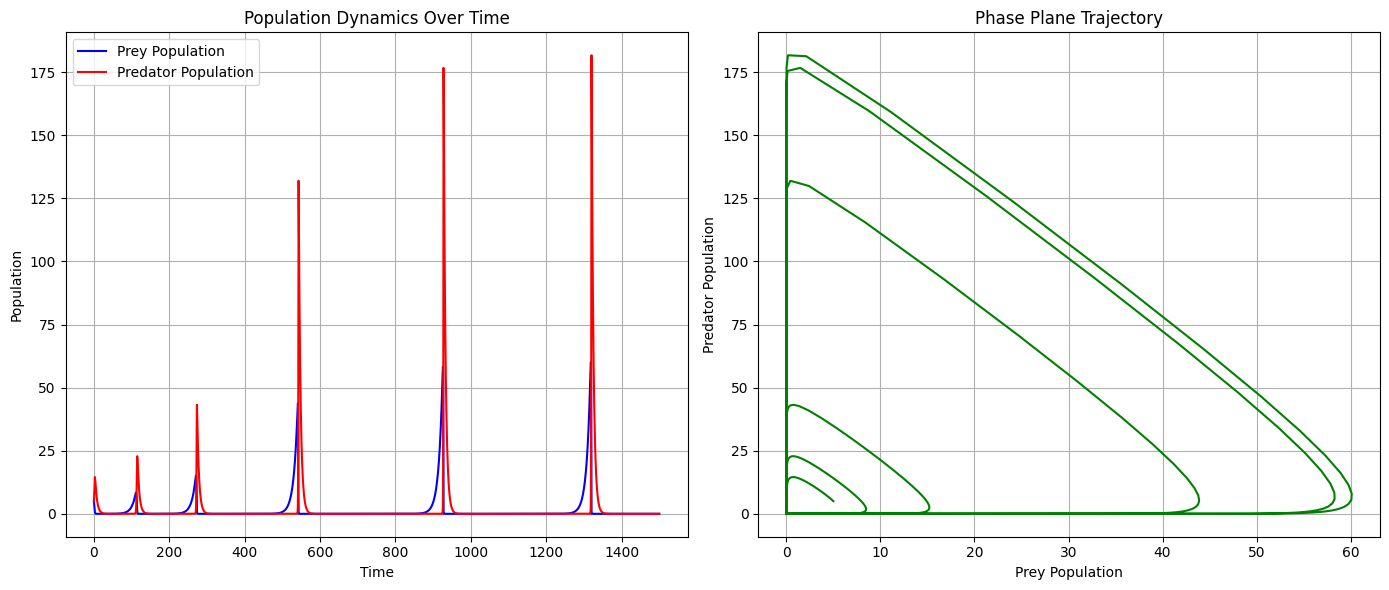

In [11]:
case = 'constant'
c = 0
d = 0

info_n2 = anlyze_nonLin_model()

**Caso A1**

Equilibrio calcolato analiticamente:
 [0.71428571 1.22142857]
Locally asymptotically stable


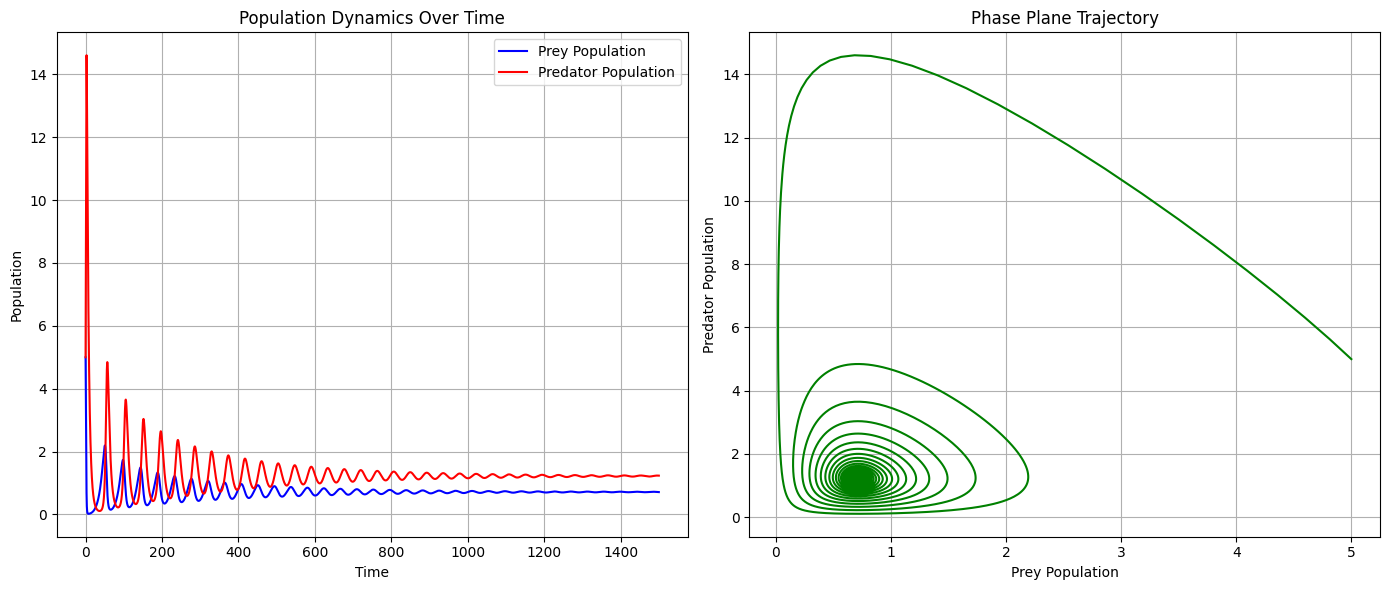

In [12]:
case = 'constant'
c = 0.01
d = 0

info_cx2 = anlyze_nonLin_model()

**Caso B1**

Equilibrio calcolato analiticamente:
 [0.67857143 1.06785714]
Locally asymptotically stable


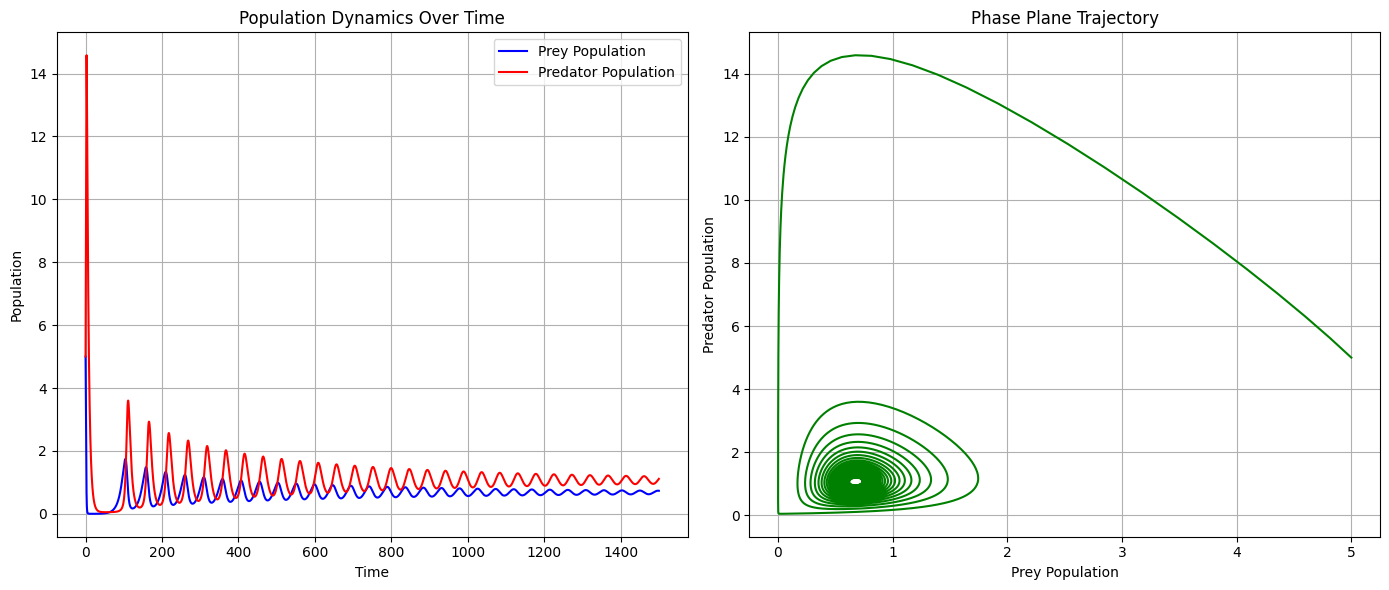

In [13]:
case = 'constant'
c = 0
d = 0.01

info_cy2 = anlyze_nonLin_model()

**Caso C1**

Equilibrio calcolato analiticamente:
 [0.71428571 1.28142857]
Locally asymptotically stable


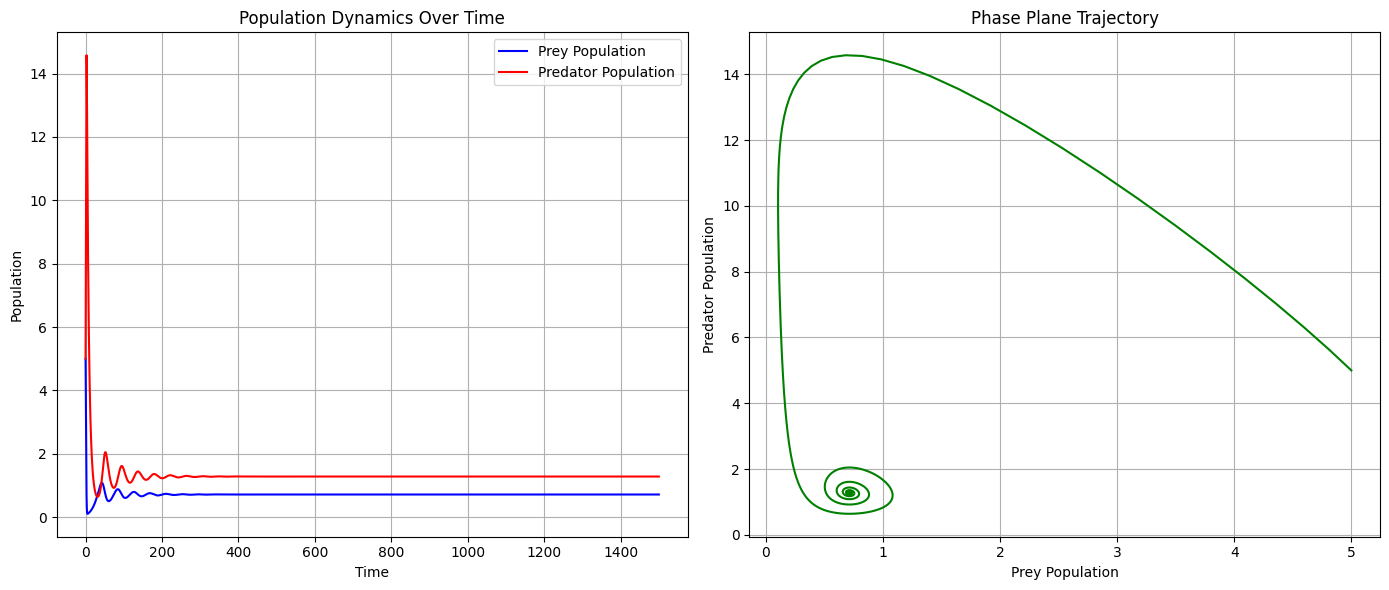

In [14]:
case = 'proportional'
c = 0.01
d = 0

info_px2 = anlyze_nonLin_model()

**Caso D1**

Equilibrio calcolato analiticamente:
 [0.68084803 1.0680848 ]
Locally asymptotically stable


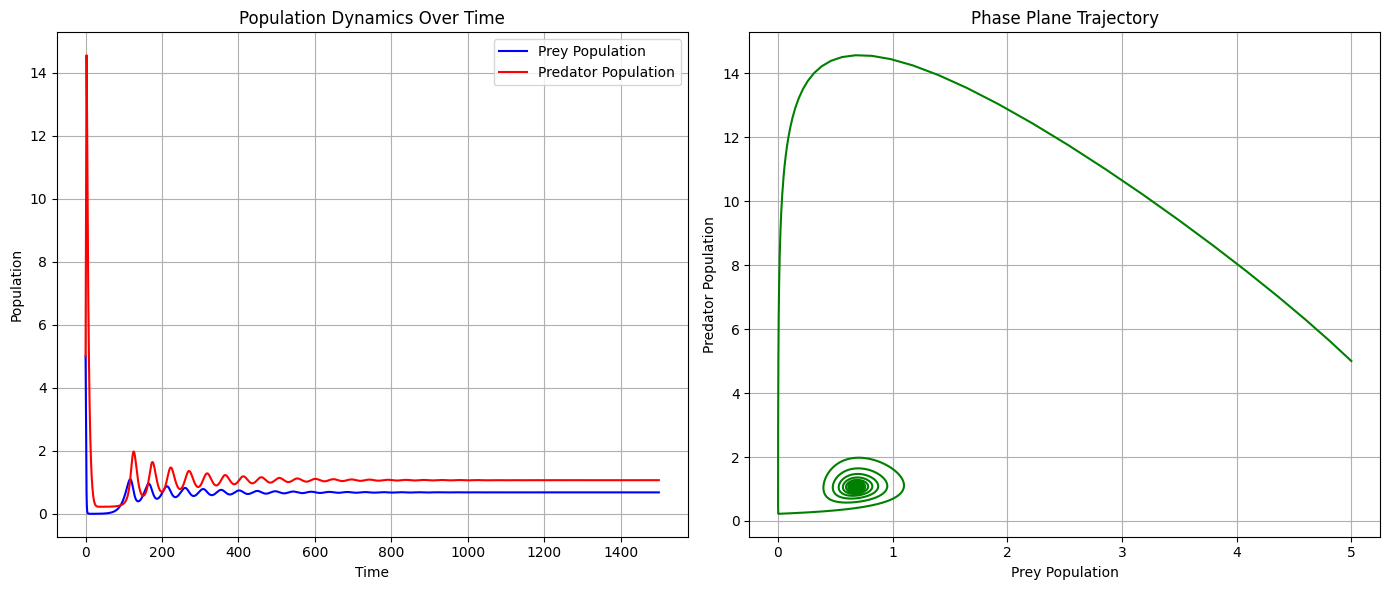

In [15]:
case = 'proportional'
c = 0
d = 0.01

info_py2 = anlyze_nonLin_model()

## Risultati Type III - Modello Sigmoidale

In [16]:
alpha = 1
h = 0.1

Utilizzando $\alpha=1$ il modello ha una risposta funzionale iperbolica definita dalle equazioni differenziali: 


\begin{cases}
\frac{dx}{dt} = rx - \frac{ax^2y}{1+hx^2} + C(x) \\
\frac{dy}{dt} = \frac{bx^2y}{1+hx^2} - my + D(y)
\end{cases}

**Caso senza immigrazione** <br>
Il punto di equilibrio è localmente asintoticamente stabile quando $\beta = rb - hmr > 0$, dove $\beta$ rappresenta il parametro di stabilità intrinseco del sistema

Equilibrio calcolato analiticamente:
 [0.84515425 1.26773138]
Locally asymptotically stable


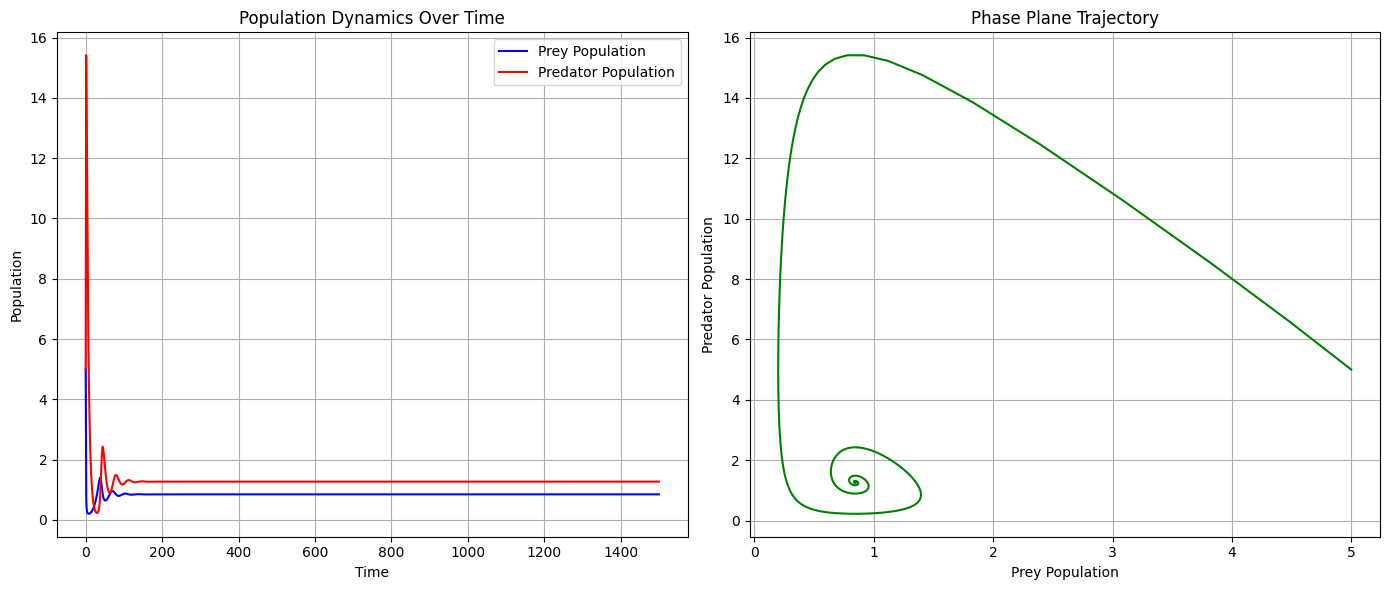

In [17]:
case_c = 'constant'
c = 0
d = 0

info_n3 = anlyze_nonLin_model()

**Caso A1**

Equilibrio calcolato analiticamente:
 [0.84515425 1.44521378]
Locally asymptotically stable


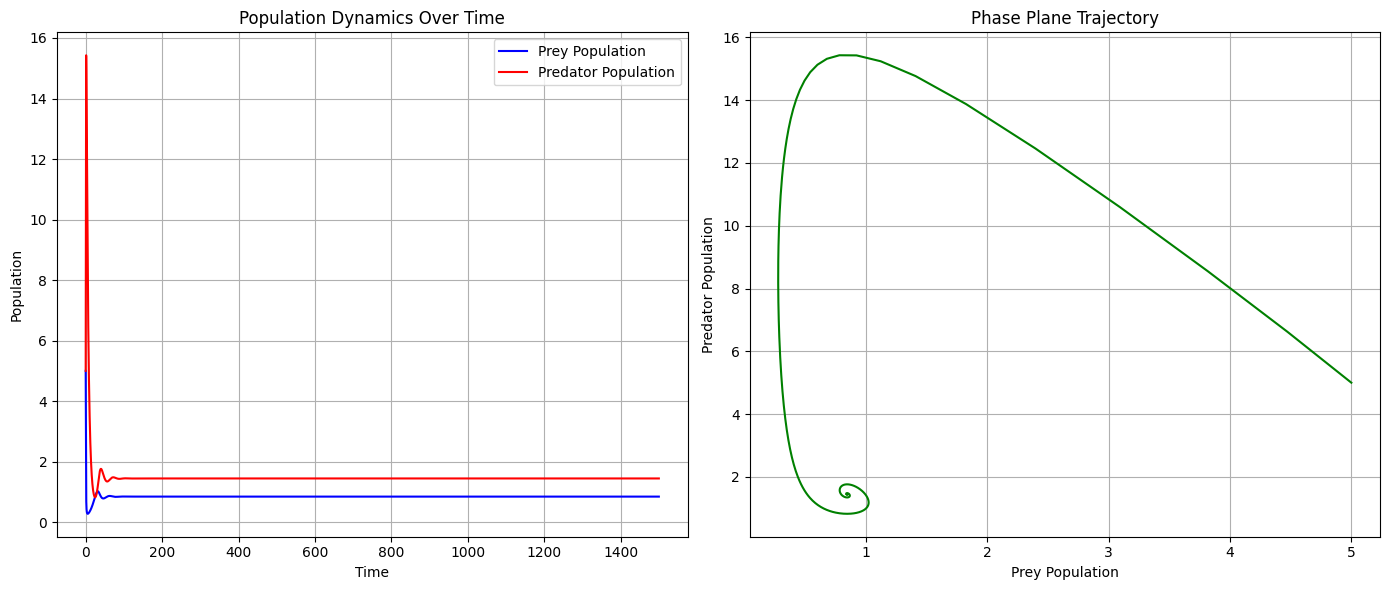

In [18]:
case_c = 'constant'
c = 0.01
d = 0

info_cx3 = anlyze_nonLin_model()

**Caso B1**

Equilibrio calcolato analiticamente:
 [0.83138203 1.28595467]
Locally asymptotically stable


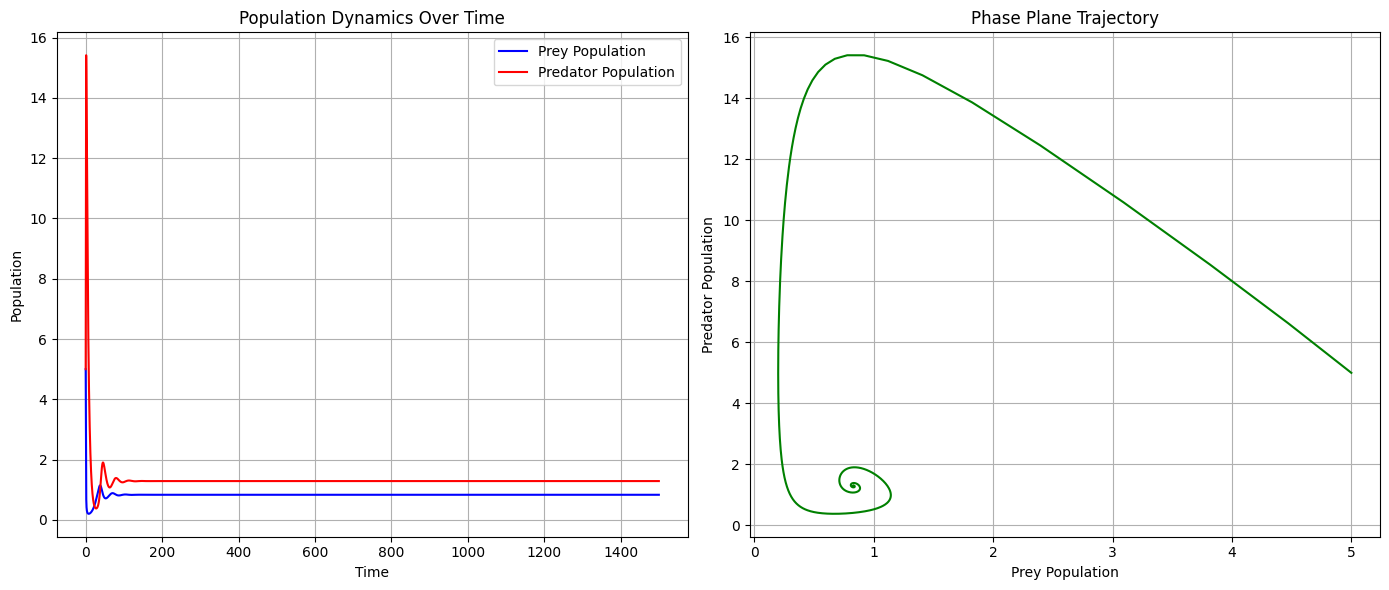

In [19]:
case_c = 'constant'
c = 0
d = 0.01

info_cy3 = anlyze_nonLin_model()

**Caso C1**

Equilibrio calcolato analiticamente:
 [0.84515425 1.44521378]
Locally asymptotically stable


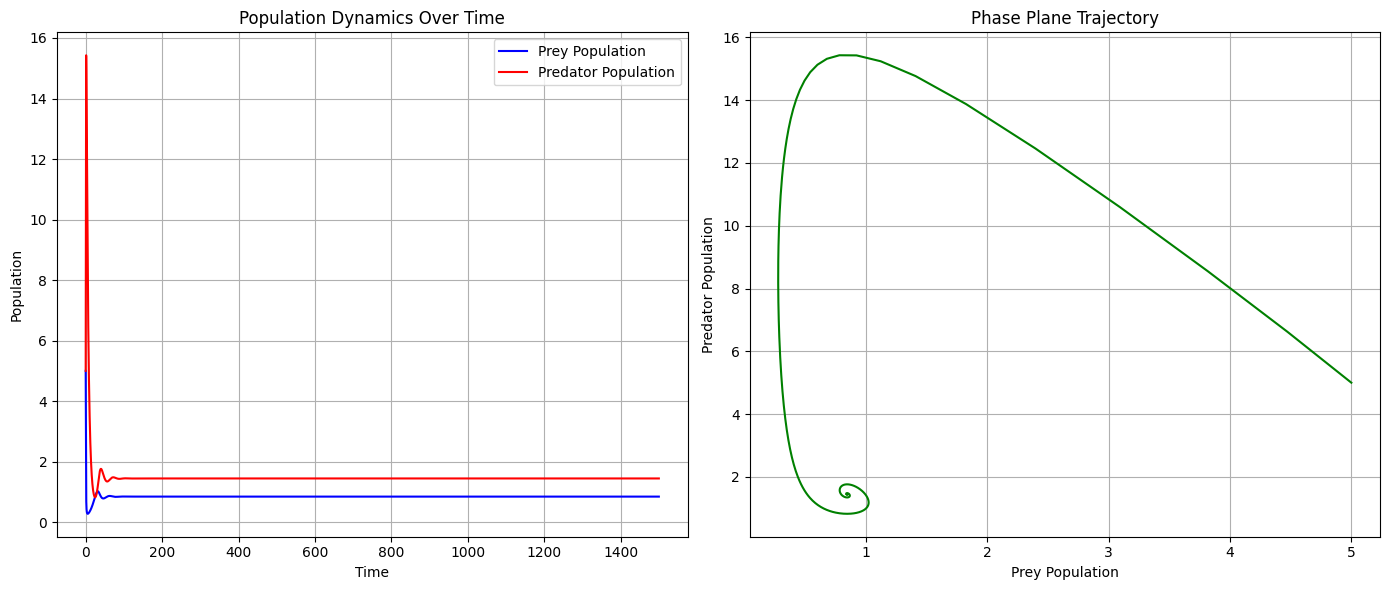

In [20]:
case_c = 'proportional'
c = 0.01
d = 0

info_px3 = anlyze_nonLin_model()

**Caso D1**

Equilibrio calcolato analiticamente:
 [0.83138203 1.28595467]
Locally asymptotically stable


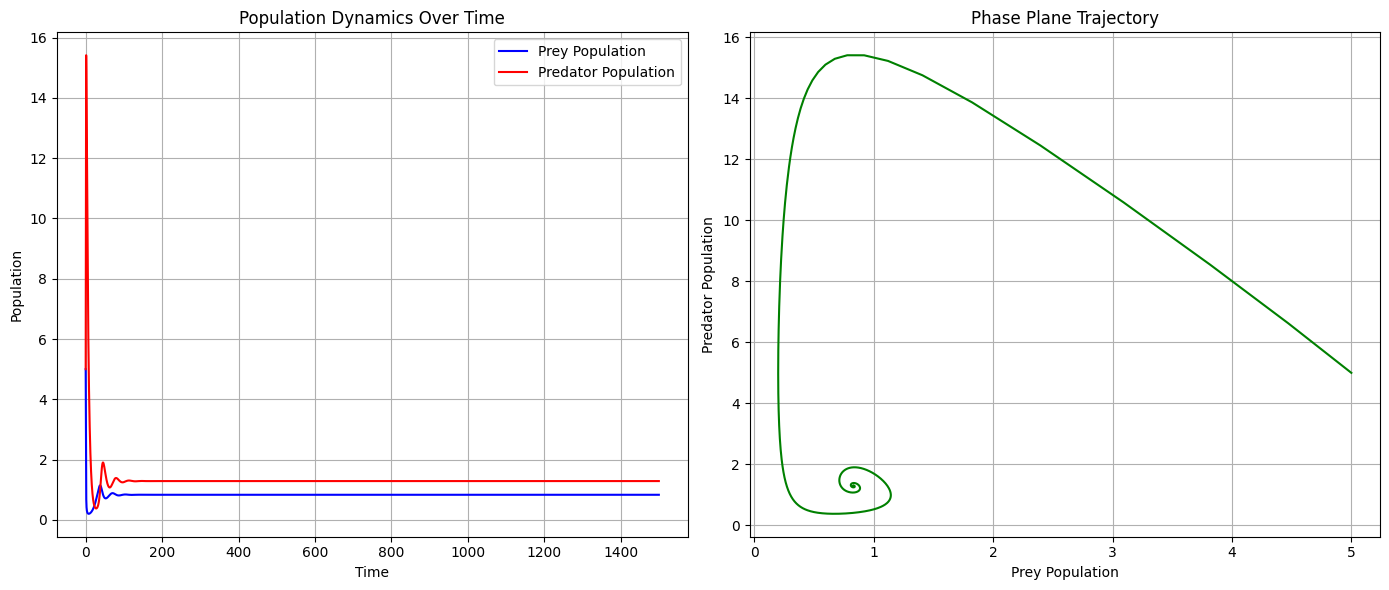

In [21]:
case_c = 'proportional'
c = 0
d = 0.01

info_py3 = anlyze_nonLin_model()

## Conclusioni - Stabilità degli equilibri

In [22]:
from tabulate import tabulate

tab_models = [
    {
        "Modello": "Tipo I (Lineare)",
        "Senza Immigrazione": info_n1["stability"],
        "Immigrazione prede costante": info_cx1["stability"],
        "Immigrazione prede proporzionale": info_px1["stability"],
        "Immigrazione predatori costante": info_cy1["stability"],
        "Immigrazione predatori proporzionale": info_py1["stability"]
    },
    {
        "Modello": "Type II (Iperbolico)",
        "Senza Immigrazione": info_n2["stability"],
        "Immigrazione prede costante": info_cx2["stability"],
        "Immigrazione prede proporzionale": info_px2["stability"],
        "Immigrazione predatori costante": info_cy2["stability"],
        "Immigrazione predatori proporzionale": info_py2["stability"]
    },
    {
        "Modello": "Type III (Sigmoid functional response)",
        "Senza Immigrazione": info_n3["stability"],
        "Immigrazione prede costante": info_cx3["stability"],
        "Immigrazione prede proporzionale": info_px3["stability"],
        "Immigrazione predatori costante": info_cy3["stability"],
        "Immigrazione predatori proporzionale": info_py3["stability"]
    }
]

print(tabulate(tab_models, headers="keys", tablefmt="rounded_outline"))    

╭────────────────────────────────────────┬───────────────────────────────┬───────────────────────────────┬────────────────────────────────────┬───────────────────────────────────┬────────────────────────────────────────╮
│ Modello                                │ Senza Immigrazione            │ Immigrazione prede costante   │ Immigrazione prede proporzionale   │ Immigrazione predatori costante   │ Immigrazione predatori proporzionale   │
├────────────────────────────────────────┼───────────────────────────────┼───────────────────────────────┼────────────────────────────────────┼───────────────────────────────────┼────────────────────────────────────────┤
│ Tipo I (Lineare)                       │ Unstable, limit cycle exists  │ Locally asymptotically stable │ Locally asymptotically stable      │ Locally asymptotically stable     │ Locally asymptotically stable          │
│ Type II (Iperbolico)                   │ Unstable                      │ Locally asymptotically stable │ Locally a

**Conclusioni**:
- Nei modelli di LV, e in particolare il modello Type I e Type II, l'introduzione di un numero **ridotto** di individui immigrati ha portato alla stabilizzazione del punto di equilibrio.
- L'immigrazione di prede e quella di predatori hanno portato entrambe ad un miglioramento.
- L'immigrazione proporzionale ($c/x$, $d/y$) presenta una limitazione teorica significativa: per popolazioni molto piccole ($x\rightarrow0$ o $y\rightarrow0$), il tasso di immigrazione tende all'infinito, rendendo il modello biologicamente irrealistico. Questo suggerisce che il modello con immigrazione costante (c, d) è più realistico per applicazioni pratiche.